<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL-Change-Detection/blob/main/ChangeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KeyError: 'ns2:getDataResponse' comes up if the station is not in [].

## Library Imports

In [1]:
# for module in [xmldict, pyod, hampel]:

#   try:
#       import module
#       print(f'{module} is not found')
#   except ModuleNotFoundError:
#     !pip install module

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
try:
    import xmltodict
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install xmltodict

In [4]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5MB 4.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
# import statsmodels.api as sm
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import datetime
import statsmodels.tsa.filters as filters
from statsmodels.tsa.filters.bk_filter import bkfilter


import requests
import xmltodict



## Helper Functions

### Web Service

In [6]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  global xml, dict_of_xml, df
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values']

  #Null values are given as OrderedDictionaries with lots of text, while actual values are given as strings.  This converts all the OrderedDictionaries into actual null/none values, and converts all values that were given as strings into float numbers.
  df = pd.DataFrame(map(lambda i: float(i) if type(i) == str else None, df))

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)

  return df.iloc[:,0].astype(float)  #For some reason converting strings to floats can only be done in return.


In [7]:
# Function to Download Multiple Stations at a time from AWDB Web Service.  
# Not the most efficient way as it sends multiple requests.  Should change SOAP to accept multiple inserted stationtriplets in future.

def getData(stations, parameter_of_interest, begindate, enddate):
  
  try:
    data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])  
    data_singleDF.columns = [f'{j}' for j in stations]
  except ValueError:
    print('One or more of the values for an inputed date in the Air-Water Database (AWDB) is null.  Need to either select a different date or update the value using DMP in AWDB.')

  return pd.DataFrame(data_singleDF)

In [8]:
# df = getData(['464:OR:SNTL'], 'WTEQ', '01/01/2020', '05/25/2021')

### Change Detection

#### Double Mass

In [9]:
def double_mass(stations, parameter, begindate, enddate, month=0):  
  # global site_list, df_merged, df2
 #Compile and filter data with respect to inputs:
  # site_list = [ORWA_Sites2[i][parameter] for i in stations] #Use if loading data from a csv
  site_list = [getData([i], parameter, begindate, enddate) for i in stations]
 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged
  df2.columns = [f'{i} {parameter}' for i in stations]
  
  if month == 0:
    df2 = df2
    # print(df2) 
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indices better.  When to use .dt accessor?

#Double Mass Analysis
  x=pd.DataFrame(abs(df2.iloc[:,0].diff()).cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([abs(df2.iloc[:,i].diff()).cumsum() for i in range(len(stations))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Plot the data
  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  fig = make_subplots(
      rows=1, cols=1,
      subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
      name = 'Double mass curve'
  ), 
  row=1, col=1)

  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}", row=1, col=1)
  fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{stations[1::]}</br>", row=1, col=1)

  fig.update_layout(
   height=800,
   width=1200
  )
  
  fig.show()

#### Pre/Post plots

In [181]:
#Ticks are overlapping due to plotting xaxis for both PreMean and PostMean

def PrePostPlots(station, paramater, begindate, enddate, eventdate):
  global df, PreEvent, PreMean, PostEvent, PostMean, Means
  df = getData(station, paramater, begindate, enddate)
  # df['Date'] = pd.to_datetime(df['Date'])
  # df = df.set_index(df['Date'])

  #Remove Feb. 29/leap year as it messes everything up
  df = df[~((df.index.month == 2) & (df.index.day == 29))]
  df['month-day'] = df.index.strftime('%m-%d')
  # pivoted = df.pivot(index="WTEQ", columns="month-day")

  PreEvent = df[:eventdate]
  PostEvent = df[eventdate:]

  PreMean = PreEvent.groupby(by='month-day').mean()
  PostMean = PostEvent.groupby(by='month-day').mean()
  # PreMean = PreEvent.groupby(pd.Grouper(freq='D')).mean()
  # df[(df['Delivery Date'].dt.year == 1970) | (df['Delivery Date'] >= sixmonthago)]
  # PreMean['Date'] = pd.date_range('01-01-1990','12-31-1990',freq='d').strftime('%m-%d')
  # PreMean.columns = ['WTEQ','Date']
  # PreMean.set_index('Date', inplace=True)
  # return PreEvent #, PreMean

  #In order for xaxis labels not to be duplicated creating overlapping values on xaxis, combine PreMean and PostMean into single df so they both share a single 'month-day' index.
  Means = pd.merge(PreMean, PostMean, right_index=True, left_index=True)
  # Means.columns = []
  # return df.groupby([df.index.day,df.index.month]).mean()

  # fig = make_subplots(
  #     rows=1, cols=1,
  #     # subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  # )
  # # PreMean.reset_index(inplace=True)
  # # PostMean.reset_index(inplace=True)


  # fig = go.Figure()
  # fig.add_trace(go.Scatter(
  #     x=Means.index,
  #     y=Means['WTEQ_x'],
  #     mode='lines'
  # ))

  # fig.add_trace(go.Scatter(
  #     x=Means.index,
  #     y=Means['WTEQ_y'],
  #     mode='lines'
  # ))

  # fig.update_layout(
  #  height=800,
  #  width=1200
  # )
  
  # fig.show()
 
  
  Means.reset_index(inplace=True)

  fig, ax = plt.subplots(figsize=(20,12))
  ax.plot(Means.index, Means['WTEQ_x'], color='blue', label = 'Daily Mean Values before Event')
  ax.plot(Means.index, Means['WTEQ_y'], color='red', label = 'Daily Mean Values after Event')
  # ax.set(xticks=np.arange(PostMean['month-day'].size), xticklabels=datelabels) #Same as plt.xticks
  # plt.tick_params(axis = 'x', width = 1, which='major') #left = False, bottom = False)
  # ax.set_xticks(df['month-day']) #step 5 digits
  plt.legend()
  plt.show();


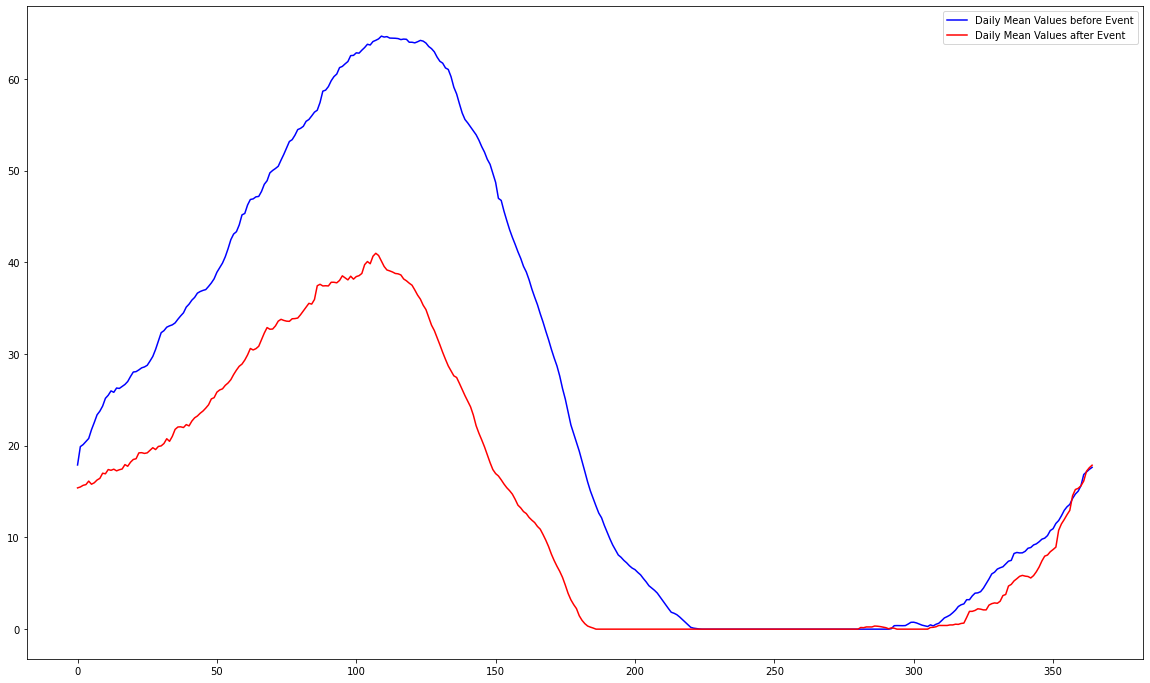

In [182]:
a = PrePostPlots(['908:WA:SNTL'], 'WTEQ','11/25/2005', '12/18/2019', '01/01/2015')

In [157]:
Means

,WTEQ_x,WTEQ_y
month-day,,
01-01,17.900000,15.400
01-02,19.900000,15.500
01-03,20.122222,15.680
01-04,20.455556,15.760
01-05,20.788889,16.140
...,...,...
12-27,15.640000,15.625
12-28,16.860000,16.150
12-29,17.140000,17.225


In [56]:
pd.to_datetime(a.index)

DatetimeIndex(['2005-11-25', '2005-11-26', '2005-11-27', '2005-11-28',
               '2005-11-29', '2005-11-30', '2005-12-01', '2005-12-02',
               '2005-12-03', '2005-12-04',
               ...
               '2009-12-23', '2009-12-24', '2009-12-25', '2009-12-26',
               '2009-12-27', '2009-12-28', '2009-12-29', '2009-12-30',
               '2009-12-31', '2010-01-01'],
              dtype='datetime64[ns]', name='Date', length=1498, freq=None)

In [78]:
c = a.groupby(pd.Grouper(freq='M')).mean()

In [80]:
a.groupby(a.index.date).mean()


,WTEQ
2005-11-25,9.7
2005-11-26,10.7
2005-11-27,10.8
2005-11-28,11.1
2005-11-29,11.4
...,...
2009-12-28,12.9
2009-12-29,13.3
2009-12-30,13.7
2009-12-31,15.0


In [75]:
a.groupby(a.index.date).mean()

,WTEQ
2005-11-25,9.7
2005-11-26,10.7
2005-11-27,10.8
2005-11-28,11.1
2005-11-29,11.4
...,...
2009-12-28,12.9
2009-12-29,13.3
2009-12-30,13.7
2009-12-31,15.0


In [45]:
b.groupby(pd.Grouper(key='WTEQ', freq='D')).sum()

TypeError: ignored

In [47]:
b.resample('1W')
print(b)

            WTEQ
Date            
2005-11-25   9.7
2005-11-26  10.7
2005-11-27  10.8
2005-11-28  11.1
2005-11-29  11.4
...          ...
2009-12-28  12.9
2009-12-29  13.3
2009-12-30  13.7
2009-12-31  15.0
2010-01-01  15.9

[1499 rows x 1 columns]


#### Peak SWE and Meltout Dates

### Analyses functions

In [ ]:
#Other functions/attributes to add to classes:

#Descriptive stats
#Null heatmap and maybe other null exploration tools
#Other logicaltests:
    # find when values deviate significantly from the precip vs swe ratio and different ratios between stations (this is essentially fitting a regression model and finding outliers)
    # tmax > tavg > tmin
#Connect it to another webcall accessing metadata/other admin or qa/qc info. ... check out the other webcalls
#Battery check script.  Filters sites with batteries below certain voltage and which have been decreasing over a period of time.
#General sensor check script?  Looks for chaotic behavoir or the known behavoir of failing sensors.
#Distribution plots

#### Summary Statistics

In [ ]:
def summary_stats(station, begindate, enddate, parameters):
  try:
    if len(parameters) == 1:
      df = getData(station, parameters[0], begindate, enddate)
    elif len(parameters) > 1:
      df = [getData(station, parameter, begindate, enddate) for parameter in parameters]
      df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df)

    return df.describe()

  except KeyError:
    print('One or more of the default parameters (PREC, WTEQ, SNWD, TAVG, TMAX, TMIN, TOBS) does not exist for this station.  Specify the parameters that do exist using the parameters kwarg.')
  except UnboundLocalError:
    print('Data does not exist for the specific date of either (or both) the begindate or enddate.  Select different dates, or enter temporary value into DMP')

In [ ]:
# summary_stats(['651:OR:SNTL'], '2018-01-01','2018-02-01', parameters=['PREC','WTEQ','SNWD'])

#### Seasonal Decomposition

In [ ]:
def seasonal_decomposition(df, method = 'STL'):
  # global sd, bk, X, df2, anomalies, stl
  
  # if method == 'naive':
  #   sd = seasonal_decompose(df, model = 'additive', period=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
  #   X = sd.resid.dropna()
  #   obs = sd.observed.dropna()
  #   # df2  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
  #   # X.plot()

  # elif method == 'BaxterKing':
  #   bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
  #   X = bk.dropna().iloc[:,0]
  #   # df2 = X
    # X.plot()

  if method == 'STL':
    stl = STL(df, robust = True, seasonal = 13)
    res = stl.fit()
    # X = res
    res.plot()
    # res.plot(observed=False, resid=True, seasonal=True, trend=True)

  elif method == 'naive' or 'BaxterKing':
    if method == 'naive':
      sd = seasonal_decompose(df, model = 'additive', period=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
      X = sd.resid.dropna()
      obs = sd.observed.dropna()
      # df2  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
      # X.plot()

    elif method == 'BaxterKing':
      bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
      X = bk.dropna().iloc[:,0]
      # df2 = X
      # X.plot()   

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:],
      mode='lines',
      name= 'Normal',
      hovertext = X.iloc[:],   
    ))

    fig.update_xaxes(title_text = 'Date')

    fig.update_layout(
      height=500,
      width=850,
    )
    fig.show()



#### Heatmap of Nulls

In [ ]:
def datanulls_check(station, begindate, enddate, parameters):

  try:  
    df = [getData(station, parameter, begindate, enddate) for parameter in parameters]
    df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df)
    fig, ax = plt.subplots(figsize=(10,8)) 
    sns.heatmap(df.isnull(), cbar=False)
  
  except KeyError:
    print('One or more of the default parameters (PREC, WTEQ, SNWD, TAVG, TMAX, TMIN, TOBS) does not exist for this station.  Specify the parameters that do exist using the parameters kwarg.')



# Test Runs

In [ ]:
# getData(['AGP:BC:MSNT'], 'WTEQ', '11/25/2010', '12/18/2019')

#### Double Mass

In [ ]:
double_mass(['912:WA:SNTL','908:WA:SNTL','791:WA:SNTL'], 'PREC', '2010-01-01', '2019-01-01')

In [ ]:
getData(['912:WA:SNTL'],'WTEQ','2018-01-01', '2019-01-01')

,WTEQ
Date,
2018-01-01,11.7
2018-01-02,11.8
2018-01-03,11.8
2018-01-04,11.9
2018-01-05,11.7
...,...
2018-12-28,5.4
2018-12-29,6.8
2018-12-30,6.4


In [ ]:
getData(['791:WA:SNTL'],'WTEQ','2018-01-01', '2019-01-01')

,WTEQ
Date,
2018-01-01,17.0
2018-01-02,16.7
2018-01-03,16.6
2018-01-04,16.7
2018-01-05,16.9
...,...
2018-12-28,14.8
2018-12-29,15.3
2018-12-30,16.6


In [ ]:
getData(['908:WA:SNTL'],'PREC','2018-01-01', '2019-01-01')

,PREC
Date,
2018-01-01,62.5
2018-01-02,62.5
2018-01-03,62.5
2018-01-04,62.5
2018-01-05,62.5
...,...
2018-12-28,51.0
2018-12-29,53.4
2018-12-30,56.5
